In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
import gc
import sys
import time
import gc
import itertools
import tqdm
import time

from sklearn.preprocessing import LabelEncoder
import scipy.stats as ss

if os.name=='nt':
    try:
        mingw_path = 'C:\\Program Files\\mingw-w64\\x86_64-8.1.0-posix-seh-rt_v6-rev0\\mingw64\\bin'
        os.environ['PATH'] = mingw_path + ';' + os.environ['PATH']
    except:
        pass
    
import xgboost as xgb
from sklearn.metrics import mean_squared_error 
from numba import jit

%matplotlib inline

In [2]:
# Load data
train = pd.read_csv('all/sales_train.csv.gz')
test = pd.read_csv('all/test.csv.gz')
shop = pd.read_csv('all/shops-translated.csv')
item = pd.read_csv('all/item_category.csv')

test.set_index('ID', inplace=True)
item.drop(['item_name_translated'], axis=1, inplace=True)
shop.drop(['Name'], axis=1, inplace=True)

le = LabelEncoder()
item['item_cat1'] = le.fit_transform(item['item_cat1'].astype(str))
item['item_cat2'] = le.fit_transform(item['item_cat2'].astype(str))
shop['City'] = le.fit_transform(shop['City'])
shop['Type'] = le.fit_transform(shop['Type'])

# test = test.merge(item, on='item_id', how='left')
# test = test.merge(shop, on='shop_id', how='left')

In [3]:
# count of sales per month
cnt = train.pivot_table(index=['shop_id', 'item_id'],
                        columns=['date_block_num'],
                        values='item_cnt_day',
                        aggfunc='sum').fillna(0.0)

cnt = test.join(cnt, on=['shop_id', 'item_id'], how='left').fillna(0.0)
cnt.drop(['shop_id', 'item_id'], axis=1, inplace=True)
cnt.columns = ['cnt_'+str(k) for k in cnt.columns]

In [4]:
# total value of sales per month
train['sales'] = train['item_cnt_day']*train['item_price']
sales = train.pivot_table(index=['shop_id', 'item_id'],
                         columns='date_block_num',
                         values='sales',
                         aggfunc=np.sum).fillna(0.0)

sales = test.join(sales, on=['shop_id', 'item_id'], how='left').fillna(0.0)
sales.drop(['shop_id', 'item_id'], axis=1, inplace=True)
sales.columns = ['sales_'+str(k) for k in sales.columns]

In [5]:
test_shop_item = test.merge(shop, on=['shop_id'], how='left')
test_shop_item = test_shop_item.merge(item, on=['item_id'], how='left')

### Mean Encoding

In [6]:
# Apply pivot table with combinations of the following parameters
index_list = ['item_id', 'shop_id', 'City', 'Type', 'item_cat1', 'item_cat2']
column_list = ['date_block_num']
value_list = ['item_price', 'item_cnt_day'] # ['item_price', 'item_cnt_day', 'sales']
aggfunc_list = [np.sum, np.mean]

In [7]:
x = train.merge(shop, on='shop_id', how='left')
x = x.merge(item, on='item_id', how='left')

In [8]:
cols_drop = ['shop_id', 'item_id', 'City', 'Type', 'item_cat1', 'item_cat2']

In [9]:
feature_dict2 = {}
for idx, col, val, agf in tqdm.tqdm_notebook(list(itertools.product(index_list, column_list, value_list, aggfunc_list))):
    tmp = x.pivot_table(index=idx, columns=col, values=val, aggfunc=agf).fillna(0.0)
    tmp_name = '-'.join([idx, val, str(agf).split(' ')[1]])
    tmp.columns = [tmp_name+'_'+str(k) for k in tmp.columns]
    tmp = test_shop_item.merge(tmp, on=idx, how='left').fillna(0.0)
    tmp.drop(cols_drop, axis=1, inplace=True)
    feature_dict2[tmp_name] = tmp

In [10]:
feature_dict2.keys()

dict_keys(['item_id-item_price-sum', 'item_id-item_price-mean', 'item_id-item_cnt_day-sum', 'item_id-item_cnt_day-mean', 'shop_id-item_price-sum', 'shop_id-item_price-mean', 'shop_id-item_cnt_day-sum', 'shop_id-item_cnt_day-mean', 'City-item_price-sum', 'City-item_price-mean', 'City-item_cnt_day-sum', 'City-item_cnt_day-mean', 'Type-item_price-sum', 'Type-item_price-mean', 'Type-item_cnt_day-sum', 'Type-item_cnt_day-mean', 'item_cat1-item_price-sum', 'item_cat1-item_price-mean', 'item_cat1-item_cnt_day-sum', 'item_cat1-item_cnt_day-mean', 'item_cat2-item_price-sum', 'item_cat2-item_price-mean', 'item_cat2-item_cnt_day-sum', 'item_cat2-item_cnt_day-mean'])

### CV

In [11]:
month_in_model = 31
month_in_cv = list(range(month_in_model, 34))
cols_train = {k: list(range(k-month_in_model, k)) for k in month_in_cv}

In [12]:
#x_train = {k: pd.concat((test_shop_item, 
#           cnt.iloc[:, cols_train[k]], 
#           sales.iloc[:, cols_train[k]]), 
#           axis=1, sort=False) for k in month_in_cv}
# x_train = {m: pd.concat()for m in month_in_cv}
x_train = {}
for m in month_in_cv:
    print(m)
    df_list = [test_shop_item, 
               cnt.iloc[:, cols_train[m]], 
               sales.iloc[:, cols_train[m]]]
    df_list.extend([feature_dict2[k].iloc[:, cols_train[m]] 
                    for k in feature_dict2.keys()])
    x_train[m] = pd.concat(df_list, axis=1, sort=False).values
y_train = {k: cnt.iloc[:, k].values for k in month_in_cv}

31
32
33


In [13]:
def clip_rmse(preds, dtrain):
    y_test = np.array(dtrain.get_label())
    preds = np.array(preds)
    y_test = np.maximum(np.minimum(y_test, 20), 0)
    preds = np.maximum(np.minimum(preds, 20), 0)
    #preds = np.array(list(map(lambda x: min(20, max(x, 0)), list(preds))))
    #y_test = np.array(list(map(lambda x: min(20, max(x, 0)), list(y_test))))
    rmse = np.sqrt(mean_squared_error(preds,y_test))
    return 'clip-rmse', rmse

In [14]:
def cv(param, n_tree, x_train, y_train, month_in_cv, verbose=False):
    '''CV'''
    progress = dict()
    
    for m in month_in_cv[:-1]:
        print('CV of month {} is started.'.format(m))
        time_start = time.time()
        progress[m] = {}
        dtrain = xgb.DMatrix(x_train[m], y_train[m], nthread=-1)
        dval = xgb.DMatrix(x_train[m+1], y_train[m+1], nthread=-1)
        watchlist = [(dtrain, 'train'), (dval, 'val')]
        
        bst = xgb.train(param, 
                        dtrain, 
                        evals=watchlist,
                        evals_result=progress[m], 
                        verbose_eval=verbose,
                        num_boost_round=n_tree,
                        feval=clip_rmse)
        
        time_end = time.time()
        
        print('CV of month {} is finished, uses {:.2f} sec, clip-rmse on val {:.2f}\n'.format(m, 
            time_end-time_start, progress[m]['val']['clip-rmse'][-1]))
        
    progress = {m: {'train': progress[m]['train']['clip-rmse'], 
            'val': progress[m]['val']['clip-rmse']} 
        for m in progress.keys()}
    progress = pd.DataFrame({(m, k): progress[m][k] 
                             for m in progress.keys() 
                             for k in progress[m].keys()})
    return progress

In [20]:
param = {'max_depth':14, 
         'subsample':0.9,
         'min_child_weight':3,
         'eta':0.03, 
         'lambda':2,
         'colsample_bytree':0.8,
         'seed':1,
         'silent':1,
         'eval_metric':'rmse',
         'maximize': False,
         'nthread':8}
n_tree = 60

progress = cv(param, n_tree, x_train, y_train, month_in_cv, verbose=True)

CV of month 31 is started.
[0]	train-rmse:2.11766	val-rmse:2.47877	train-clip-rmse:1.03168	val-clip-rmse:1.12712
[1]	train-rmse:2.07722	val-rmse:2.44856	train-clip-rmse:1.00591	val-clip-rmse:1.11261
[2]	train-rmse:2.03778	val-rmse:2.41539	train-clip-rmse:0.983276	val-clip-rmse:1.09895
[3]	train-rmse:2.00042	val-rmse:2.38964	train-clip-rmse:0.963761	val-clip-rmse:1.08781
[4]	train-rmse:1.96105	val-rmse:2.3634	train-clip-rmse:0.942438	val-clip-rmse:1.07671
[5]	train-rmse:1.92275	val-rmse:2.33782	train-clip-rmse:0.92242	val-clip-rmse:1.06653
[6]	train-rmse:1.88705	val-rmse:2.31631	train-clip-rmse:0.905522	val-clip-rmse:1.05694
[7]	train-rmse:1.85291	val-rmse:2.29236	train-clip-rmse:0.88753	val-clip-rmse:1.04999
[8]	train-rmse:1.81774	val-rmse:2.26481	train-clip-rmse:0.870646	val-clip-rmse:1.04238
[9]	train-rmse:1.7826	val-rmse:2.24279	train-clip-rmse:0.853913	val-clip-rmse:1.03592
[10]	train-rmse:1.74866	val-rmse:2.22197	train-clip-rmse:0.838223	val-clip-rmse:1.02929
[11]	train-rmse:1.717

KeyboardInterrupt: 

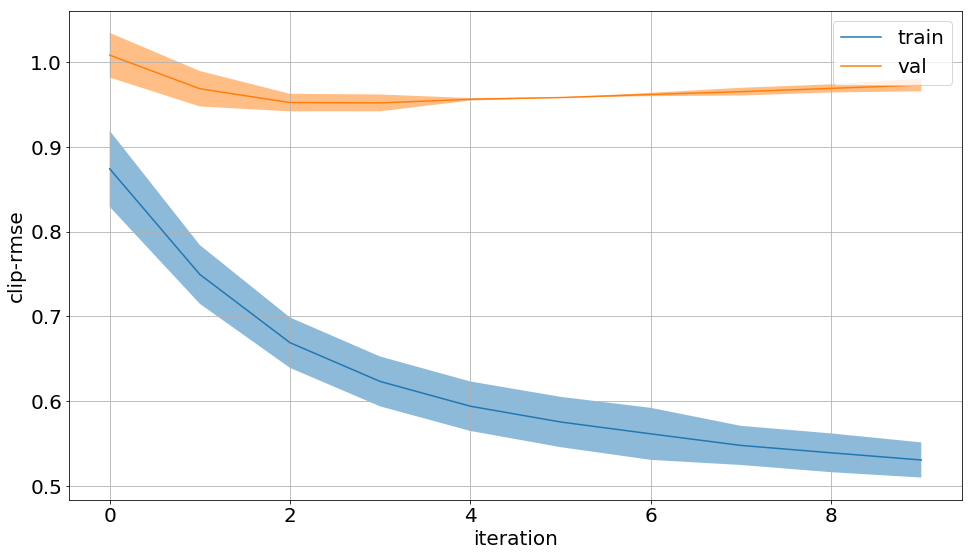

In [129]:
val_mean = progress.xs('val', axis=1, level=1).mean(axis=1)
val_std = progress.xs('val', axis=1, level=1).std(axis=1)

train_mean = progress.xs('train', axis=1, level=1).mean(axis=1)
train_std = progress.xs('train', axis=1, level=1).std(axis=1)

plt.figure(figsize=(16, 9))
plt.rcParams.update({'font.size': 20})
plt.plot(np.arange(len(train_mean)), train_mean)
plt.fill_between(np.arange(len(train_std)), 
                 train_mean-train_std, 
                 train_mean+train_std, alpha=0.5)
plt.plot(np.arange(len(val_mean)), val_mean)
plt.fill_between(np.arange(len(val_mean)), 
                 val_mean-val_std, 
                 val_mean+val_std, alpha=0.5)
plt.legend(['train', 'val'])
plt.xlabel('iteration')
plt.ylabel('clip-rmse')
plt.grid()